### MEC2015 - System Identification

#### Student: Felipe da Costa Pereira



___
#### Linear System Identification through Batch Least Squares

Exemple code

In [78]:
% MEC 2015 System identification
% Prof Helon Ayala

% 01_MQB

pkg load control;
clc
clear
close all
rng(1) % permite reproducibilidade

In [79]:
% ---- code begins

%% - generate artificial data
% spring-mass-damper system

m = 0.1; b= 1; k = 10; % parameters
s = tf('s');
G = 1/(m*s^2+b*s+k); % continuous model
Ts = 0.01; % sampling time
Gd = c2d(G,Ts) % discrete model


Transfer function 'Gd' from input 'u1' to output ...

      0.0004833 z + 0.0004675
 y1:  -----------------------
      z^2 - 1.895 z + 0.9048 

Sampling time: 0.01 s
Discrete-time model.


In [80]:
th = [-1.895 0.9048 0.0004833 0.0004675]'; % true vector of parameters

% simulation parameters
N = 1000; % simulation steps
t = (1:N)'; % time vector
sig = 0.01; % noise corrupting measurements

In [81]:
% TRAINING
uamp = 10;
yr = 1;
u = uamp*ones(N,1);
y = zeros(N,1);

Dados de treinamento (UTRA e YTRA)

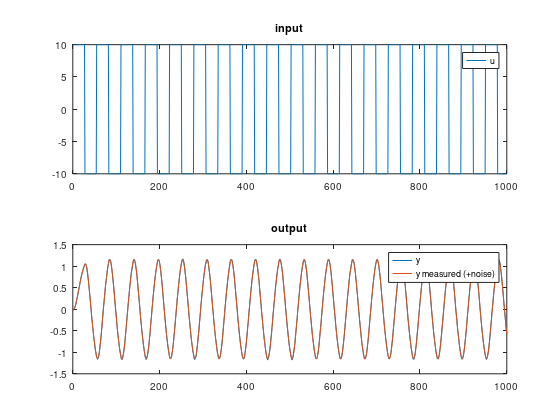

In [82]:
for k=3:N
    if y(k-1) >=  yr
        u(k) = -uamp;
    elseif y(k-1) <=  -yr
        u(k) = uamp;
    else
        u(k) = u(k-1);        
    end
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UTRA = u;
YTRA = y + sig*randn(N,1);

% plot training data
figure
subplot(2,1,1)
plot(t,UTRA)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YTRA y])
title('output')
legend('y','y measured (+noise)');


Dados de validação (UVAL e YVAL)

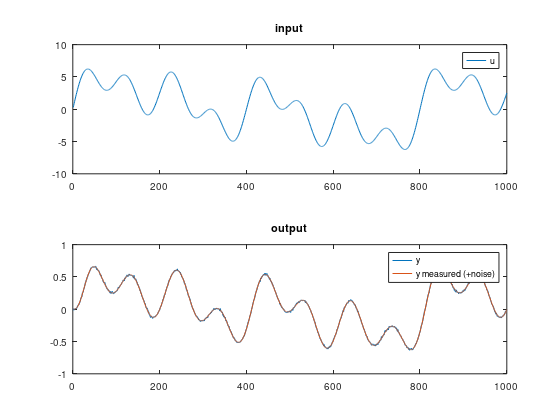

In [83]:
% VALIDATION
u = uamp/4*sin(2*pi*t*Ts) + uamp/4*sin(pi/2*t*Ts) + uamp/4*sin(pi*t*Ts) + uamp/4*sin(pi/4*t*Ts);
y = zeros(N,1);
for k=3:N
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UVAL = u;
YVAL = y + sig*randn(N,1);

% plot validation data
figure
subplot(2,1,1)
plot(t,UVAL)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YVAL y])
title('output')
legend('y','y measured (+noise)');


___
Implementing `matreg` function

In [84]:
function [Phi,yTARG] = matreg(y,u,na,nb)
    N = length(y);
    p = 1 + max(na,nb);
    Phi = [];

    if N<p  % tratando exceção do caso de N<p, caso da inicialização da simulação livre.
        Phi = [Phi; -y'(p-1:-1:p-na) u'(p-1:-1:p-nb)];
        yTARG = y(N);
    else
        for index = 0:N-p
            Phi = [Phi; -y'(p-1+index:-1:p-na+index) u'(p-1+index:-1:p-nb+index)];
        end
        yTARG = y(p:N);
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=6;
% y_ = YTRA(1:m)'
% [Phi,yTARG] = matreg(YTRA(1:m),UTRA(1:m), 2, 2);
% Phi
% yTARG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Implementing the `Free Simulation` function

In [85]:
function yhat_FS = freeSim(y,u,na,nb,th)
    p = 1 + max(na,nb);
    N = length(y);
    yhat_FS = [];
    
    y_temp = y(1:p-1);
    u_temp = u(1:p-1);
    [Phi_k, ~] = matreg(y_temp, u_temp, na, nb);
    yhat_k = Phi_k(end,:) * th;
    
    % shift circular no y_temp, u_temp (remove o da esq e add no da direita)
    y_temp = [y_temp(2:end);yhat_k];
    % u_temp = [u_temp(2:end);u(p)];
   
    % start predictions
    for k=p:N
        u_temp = [u_temp(2:end);u(k)];    
        [Phi_k, ~] = matreg(y_temp, u_temp, na, nb);
        yhat_k = Phi_k(end,:) * th;
        y_temp = [y_temp(2:end);yhat_k];
        
        % if k != N
        %     u_temp = [u_temp(2:end);u(k+1)];
        % end
        
        % store predictions
        yhat_FS = [yhat_FS;yhat_k];
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=10;
% y_ = YTRA(1:m)'
% u_ = UTRA(1:m)'
% y_pred = freeSim(YTRA(1:m),UTRA(1:m), na, nb, th_hat);
% % plot(y_pred)
% length(y_pred)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Perform identification using the `matreg` function defined above

In [86]:
%% - perform identification
na=2;
nb=2;

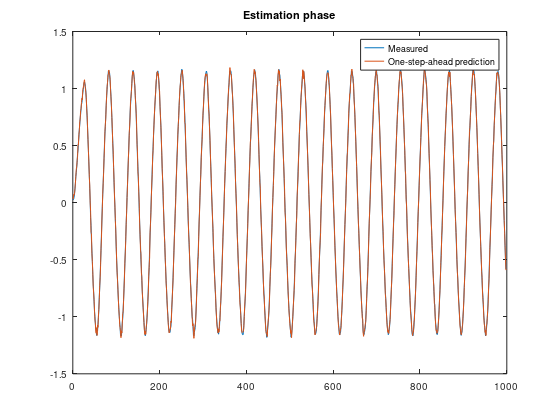

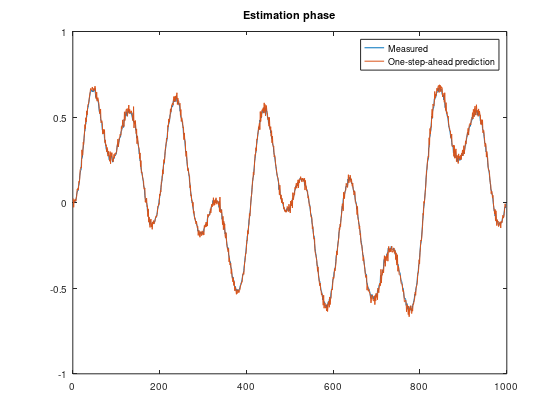

In [87]:
% construct regression matrix (using the matreg function)
[Phi, Y1] = matreg(YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

% one step ahead prediction
yhat_TRA_OSA = Phi*th_hat;
yhat_VAL_OSA = PhiVAL*th_hat;

figure
plot([Y1 yhat_TRA_OSA]), title('Estimation phase'), legend('Measured','One-step-ahead prediction')

figure
plot([Y2 yhat_VAL_OSA]), title('Estimation phase'), legend('Measured','One-step-ahead prediction')

Running `freeSim`

In [88]:
% free run simulation 
yhat_TRA_FR = freeSim(YTRA,UTRA,na,nb,th_hat);
yhat_VAL_FR = freeSim(YVAL,UVAL,na,nb,th_hat);

na = 2
nb = 2


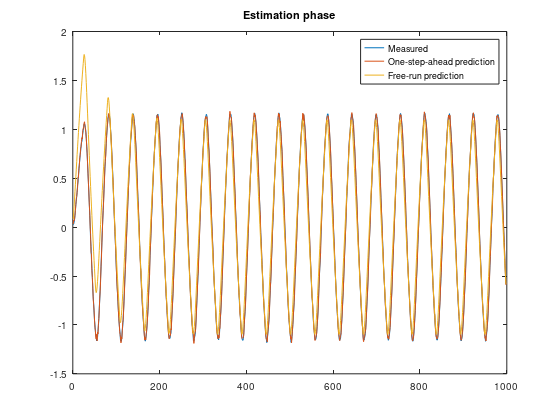

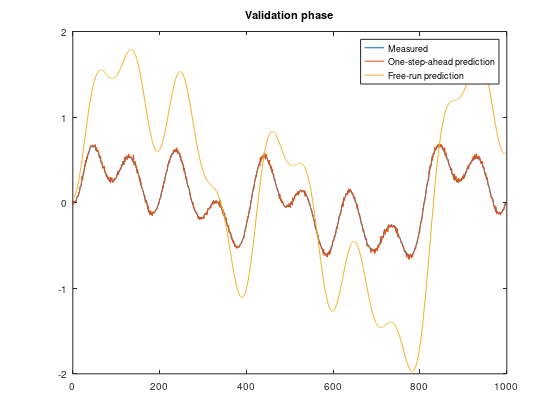

In [89]:
% max =997;

figure
% plot([Y1 yhat_TRA_OSA yhat_TRA_FR(1:max)])
plot([Y1 yhat_TRA_OSA yhat_TRA_FR])
title('Estimation phase')
legend('Measured','One-step-ahead prediction','Free-run prediction')

figure
% plot([Y2 yhat_VAL_OSA yhat_VAL_FR(1:max)])
plot([Y2 yhat_VAL_OSA yhat_VAL_FR])
title('Validation phase')
legend('Measured','One-step-ahead prediction','Free-run prediction')

na,nb

#### Real case application: robot flexible arm

___
#### Linear System Identification through Batch Least Squares

Exercise:  

Now it’s time to practice. You will identify an ARX model for a mechanical system which you assume not to know the structure.
- Go to: http://homes.esat.kuleuven.be/~smc/daisy/daisydata.html and download the “Data from a flexible robot arm”
- Read the description of the system
- Take some time to read about other benchmark case studies on the DAISy website, maybe you find something interesting for your final project 
- Read the data in MATLAB and inspect it
- Perform the following (deliver a PDF file with the results and code)
    1. Perform the identification for a number of combinations of na, nb
    2. Plot the following graphs (for estimation and validation) for all combinations of na, nb  
        - Model predictions and measured outputs  
        - Model residuals  
    3. Analyze for this dataset which could be a parsimonious model order

https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html

> Description:  
	- Data from a flexible robot arm. The arm is installed on an electrical motor. We have modeled the transfer function from the measured reaction torque of the structure on the ground to the acceleration of the flexible arm.  The applied input is a periodic sine sweep.    
	
> Columns:    
	- Column 1: input u: reaction torque of the structure   
	- Column 2: output y: accelaration of the flexible arm

Inspecting $u$ and $y$

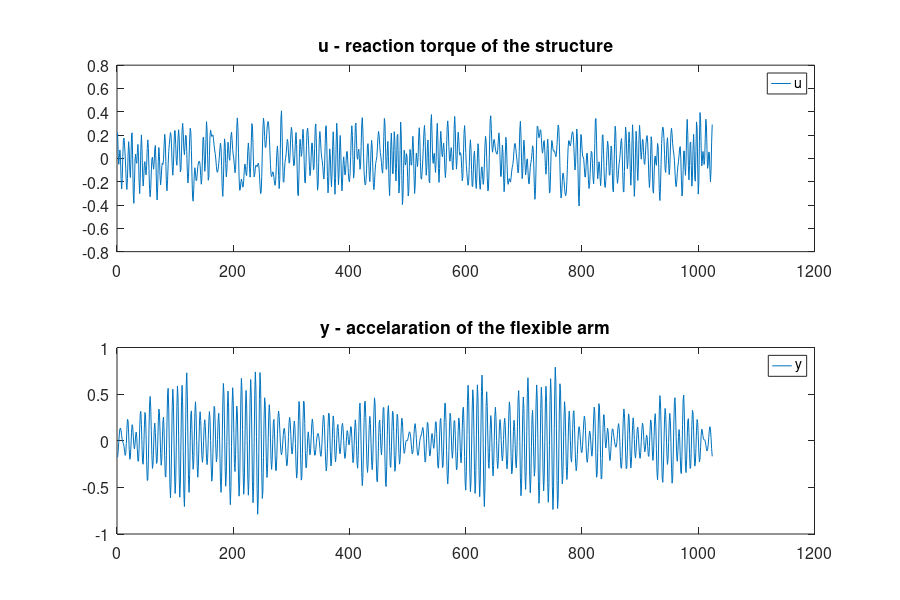

In [90]:
set(gcf, 'Position', [0 0 900 600]);
data = load('./robot_arm.dat/robot_arm.dat', '-ascii');

U = data(:,1);
Y = data(:,2);

subplot (211), plot(U), title('u - reaction torque of the structure'), legend('u');
subplot (212), plot(Y), title('y - accelaration of the flexible arm'), legend('y');

Splitting $u$ and $y$ into work (estimation) and validation data

In [91]:
UTRA=U(1:512);
UVAL=U(513:end);
YTRA=Y(1:512);
YVAL=Y(513:end);

Perform the identification for a number of combinations of na, nb

In [92]:
order_range = [2:8 10:3:16]

order_range =

    2    3    4    5    6    7    8   10   13   16



Performing Identification, plotting measured and predicted values of $y$, storing the $RMSE$ error for further comparison

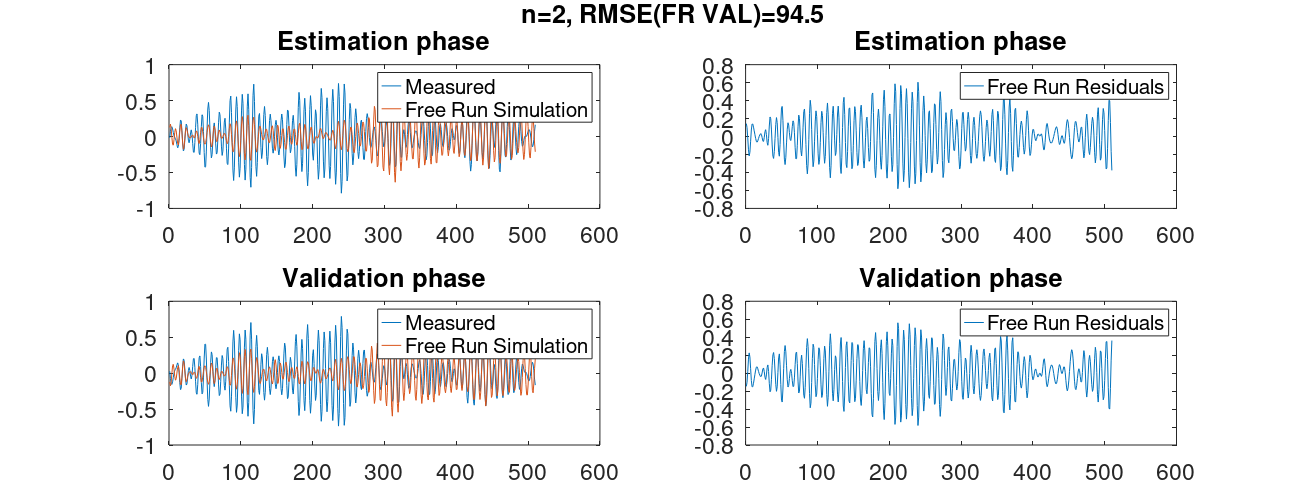

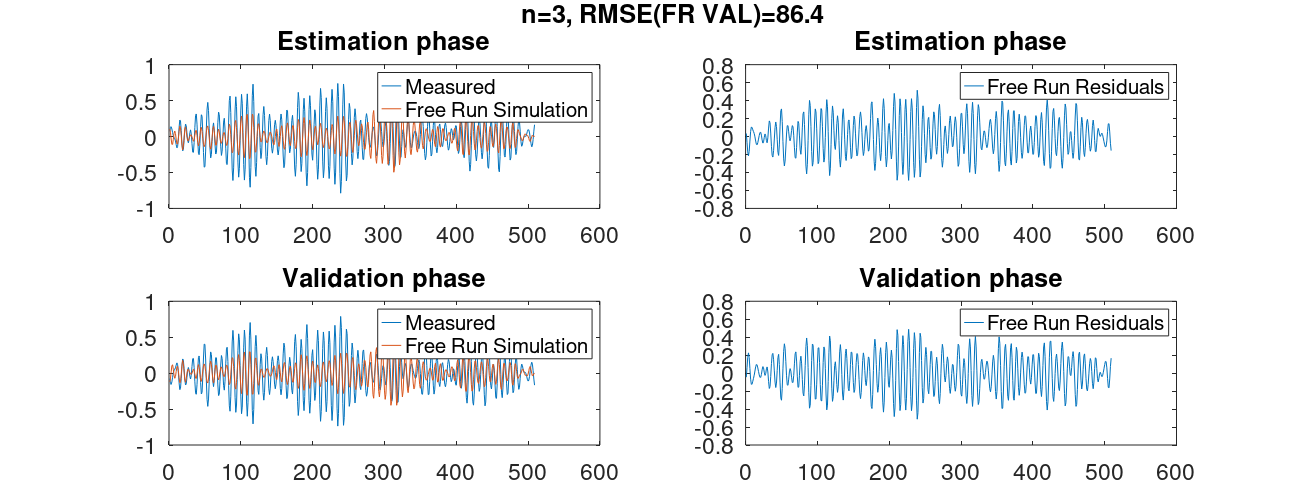

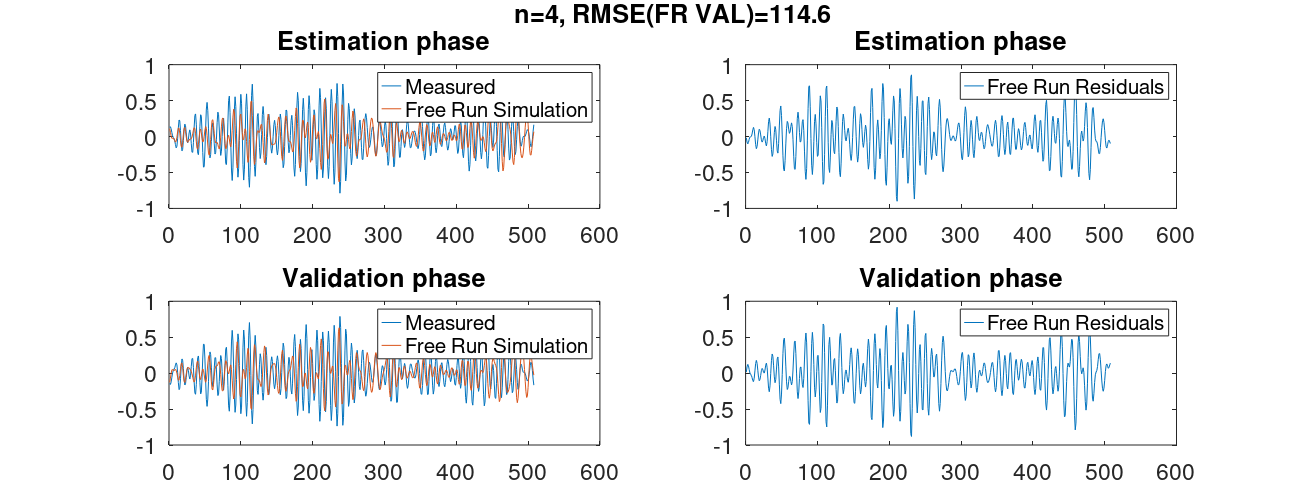

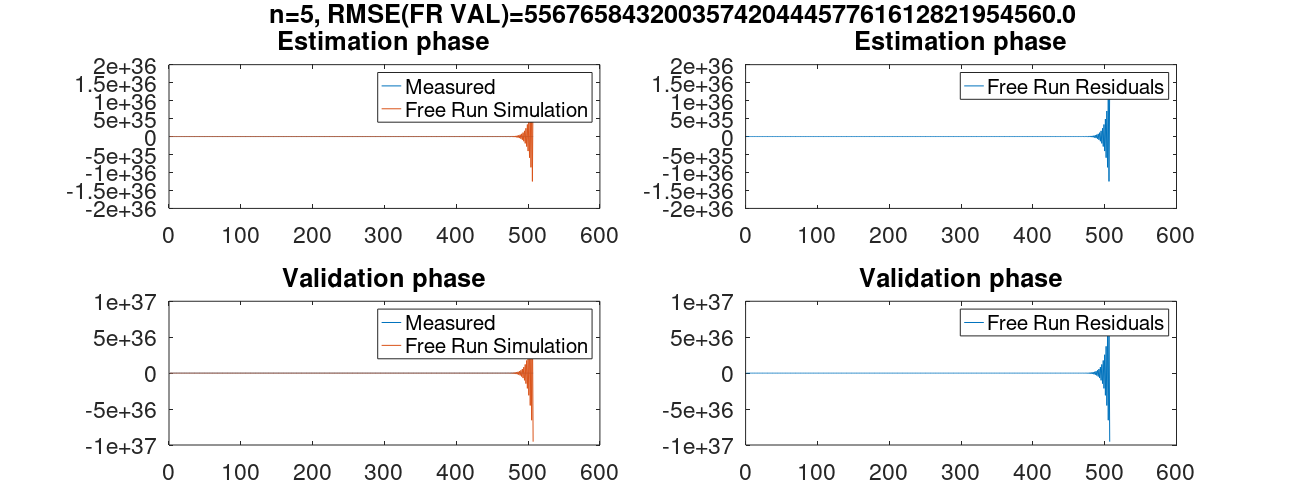

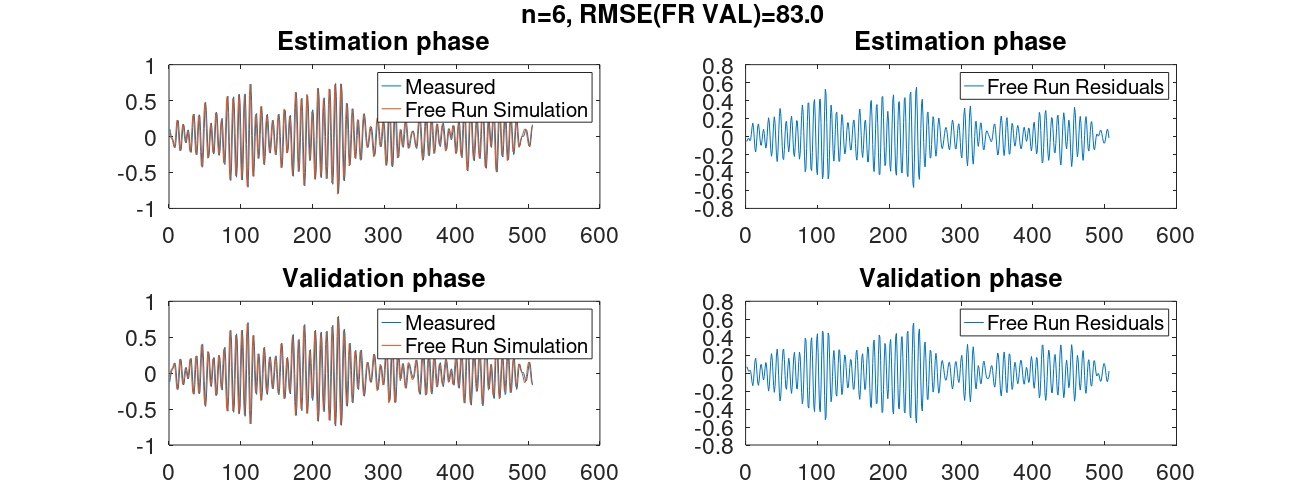

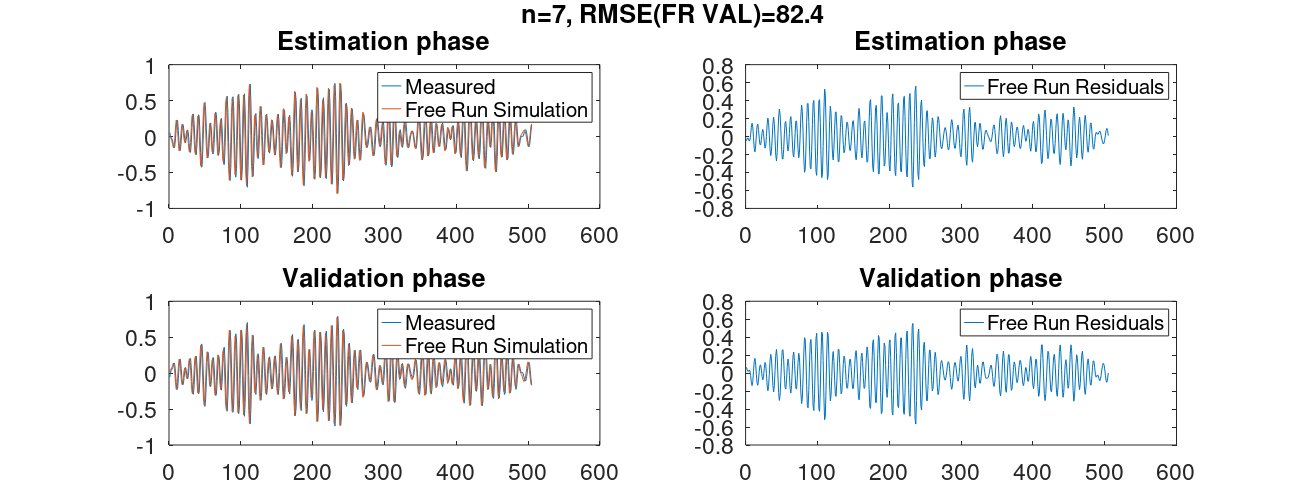

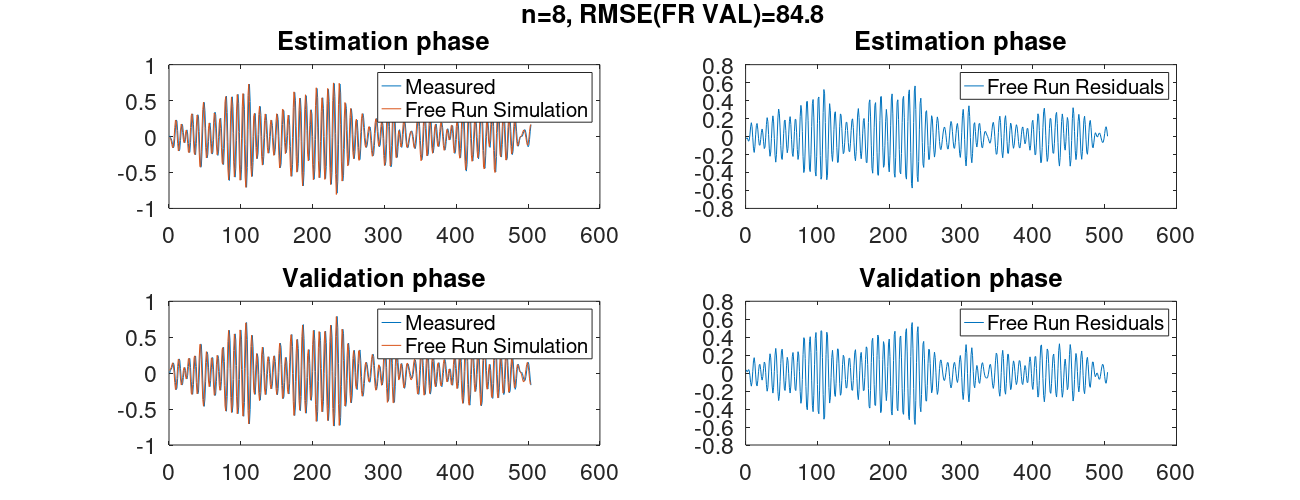

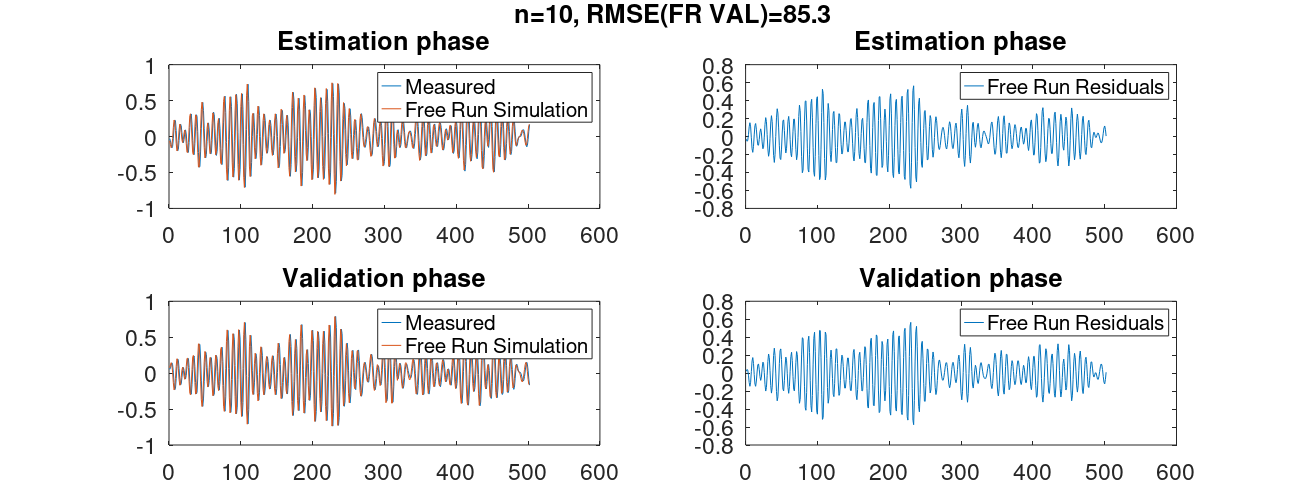

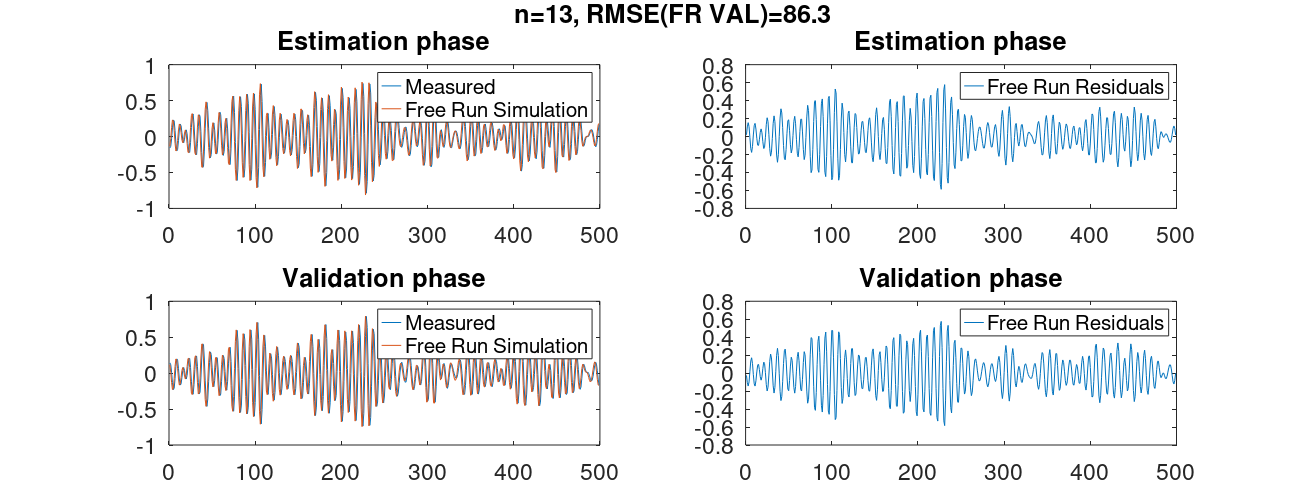

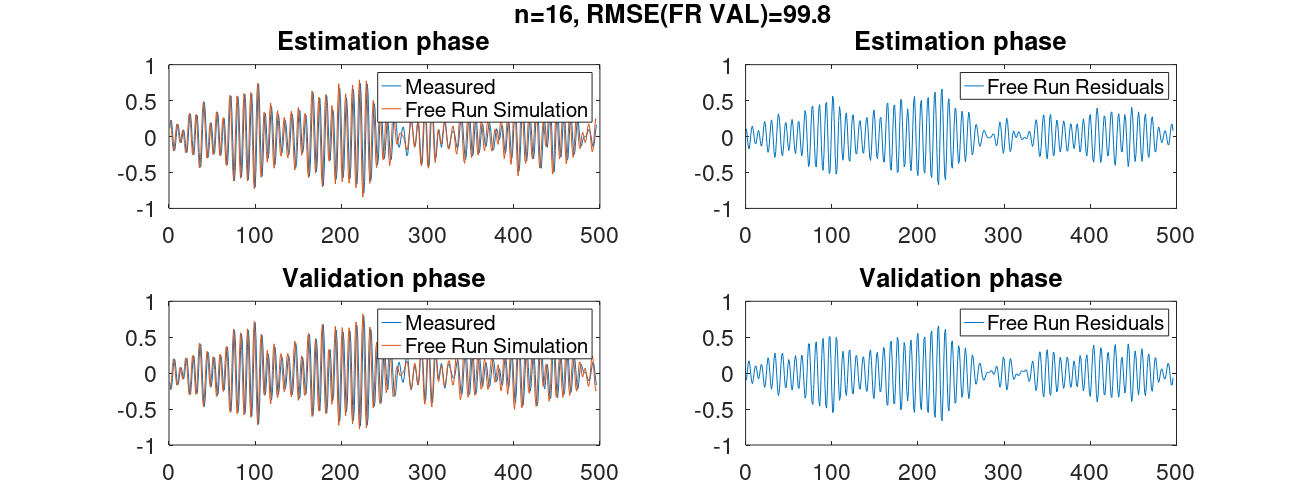

In [93]:
RMSE_VAL_OSA = [];
RMSE_VAL_FR = [];
RMSE_TRA_OSA = [];
RMSE_TRA_FR = [];

for n = order_range
    na=n;
    nb=n;

    % construct regression matrix (using the matreg function)
    [Phi, Y1] = matreg(YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

    % estimate parameters:
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

    % one step ahead prediction
    yhat_TRA_OSA = Phi*th_hat;
    yhat_VAL_OSA = PhiVAL*th_hat;

    % free run simulation 
    yhat_TRA_FR = freeSim(YTRA,UTRA,na,nb,th_hat);
    yhat_VAL_FR = freeSim(YVAL,UVAL,na,nb,th_hat);

    % Calulando erro médio quadrático
    RMSE_TRA_OSA = [RMSE_TRA_OSA; sum(sqrt((Y1-yhat_TRA_OSA).^2))];
    RMSE_TRA_FR = [RMSE_TRA_FR; sum(sqrt((Y1-yhat_TRA_FR).^2))];
    RMSE_VAL_OSA = [RMSE_VAL_OSA; sum(sqrt((Y2-yhat_VAL_OSA).^2))];
    RMSE_VAL_FR = [RMSE_VAL_FR; sum(sqrt((Y2-yhat_VAL_FR).^2))];

    figure
    set(gcf, 'Position', [0 0 1300 500]);
    hold on
    subplot (221), plot([Y1 yhat_TRA_FR]), title('Estimation phase'), legend('Measured','Free Run Simulation')
    subplot (222), plot(yhat_TRA_FR-Y1), title('Estimation phase'), legend('Free Run Residuals')
    subplot (223), plot([Y2 yhat_VAL_FR]), title('Validation phase'), legend('Measured','Free Run Simulation')
    subplot (224), plot(yhat_VAL_FR-Y2), title('Validation phase'), legend('Free Run Residuals')
    s = axes('visible', 'off', 'title', strcat('n=', int2str(na), ', RMSE(FR VAL)=', sprintf('%.1f', RMSE_VAL_FR(end))));    
    hold off
end

RMSE Error versus model order

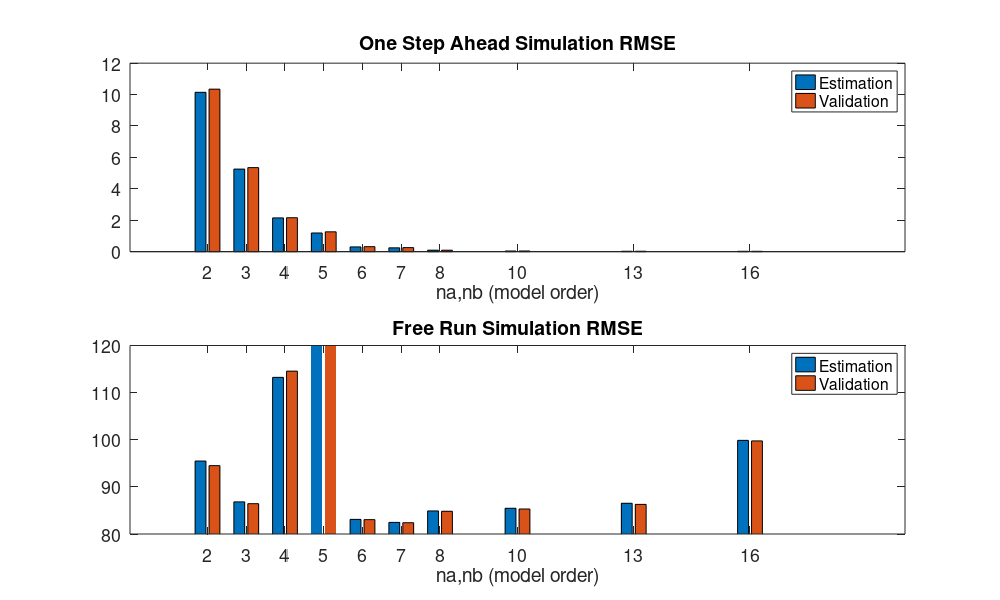

In [71]:
set(gcf, 'Position', [0 0 1000 600]);
subplot (211), bar(order_range,[RMSE_TRA_OSA RMSE_VAL_OSA]), title('One Step Ahead Simulation RMSE'), legend('Estimation', 'Validation'), xlabel('na,nb (model order)')
subplot (212), bar(order_range,[RMSE_TRA_FR RMSE_VAL_FR]), , title('Free Run Simulation RMSE'), legend('Estimation', 'Validation'), xlabel('na,nb (model order)'), ylim([80 120])

#### Comments on the results:   

> - With $n_{a}=n_{b}=5$, the model gets unstable and the RMSE explodes  
> - The ideia of choosing the model order as simple as possible leads to a choice of $n=3$, as its RMSE values are similar to orders $n=6$ and $n=7$, but when we plot the timeseries of those orders, it's more reasonable to choose $n=6$ or $n=7$  
> - For the model orders tested, the RMSE error always decreases as the order increases in the One Step Ahead Simulation, but it has an optimal order in the Free Run Simulation ($n=7$), as the RMSE errors start to increase again for higher orders.     

Choosing $n_{a} = n_{b} = 7$ as the best model order.   
Time series plots

In [94]:
na=7;
nb=7;
% construct regression matrix (using the matreg function)
[Phi, Y1] = matreg(YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

% one step ahead prediction
yhat_TRA_OSA = Phi*th_hat;
yhat_VAL_OSA = PhiVAL*th_hat;

% free run simulation 
yhat_TRA_FR = freeSim(YTRA,UTRA,na,nb,th_hat);
yhat_VAL_FR = freeSim(YVAL,UVAL,na,nb,th_hat);

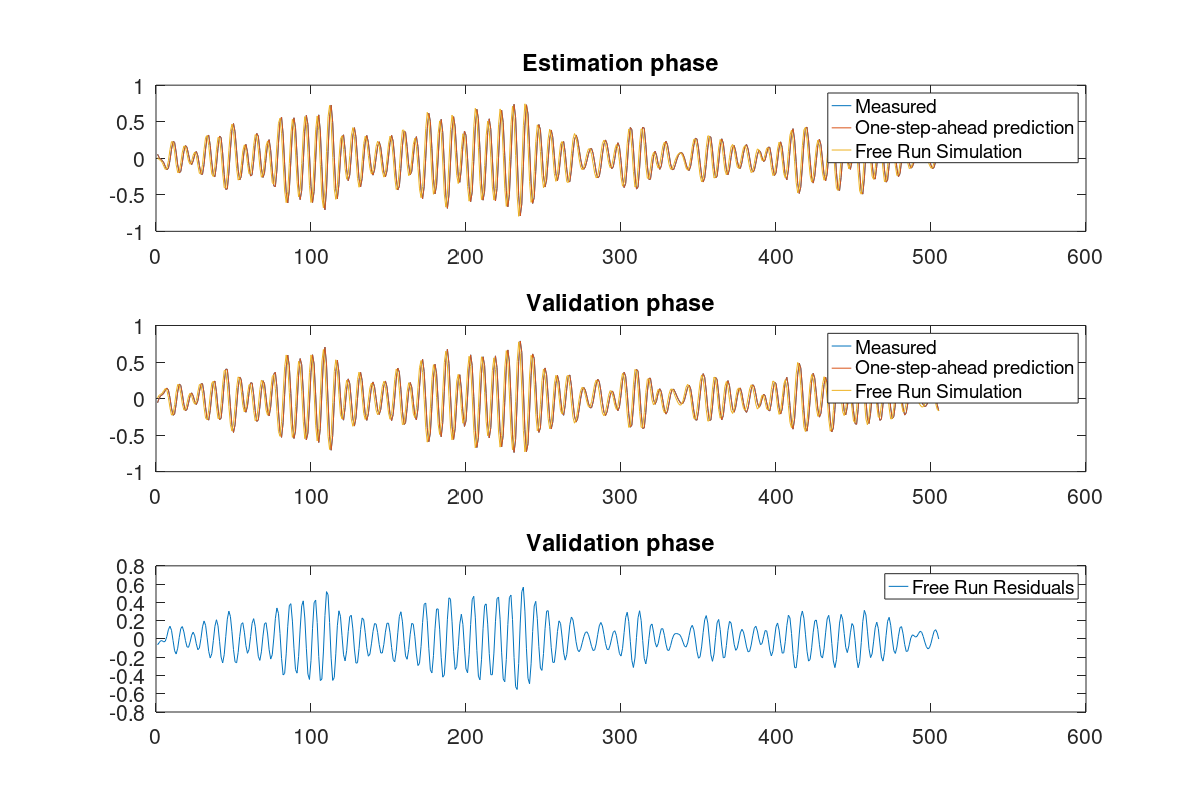

In [95]:
set(gcf, 'Position', [0 0 1200 800]);
subplot (311), plot([Y1 yhat_TRA_OSA yhat_TRA_FR]), title('Estimation phase'), legend('Measured','One-step-ahead prediction', 'Free Run Simulation')
subplot (312), plot([Y2 yhat_VAL_OSA yhat_VAL_FR]), title('Validation phase'), legend('Measured','One-step-ahead prediction', 'Free Run Simulation')
subplot (313), plot([Y2 - yhat_VAL_FR]), title('Validation phase'), legend('Free Run Residuals')